## EDA

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defa

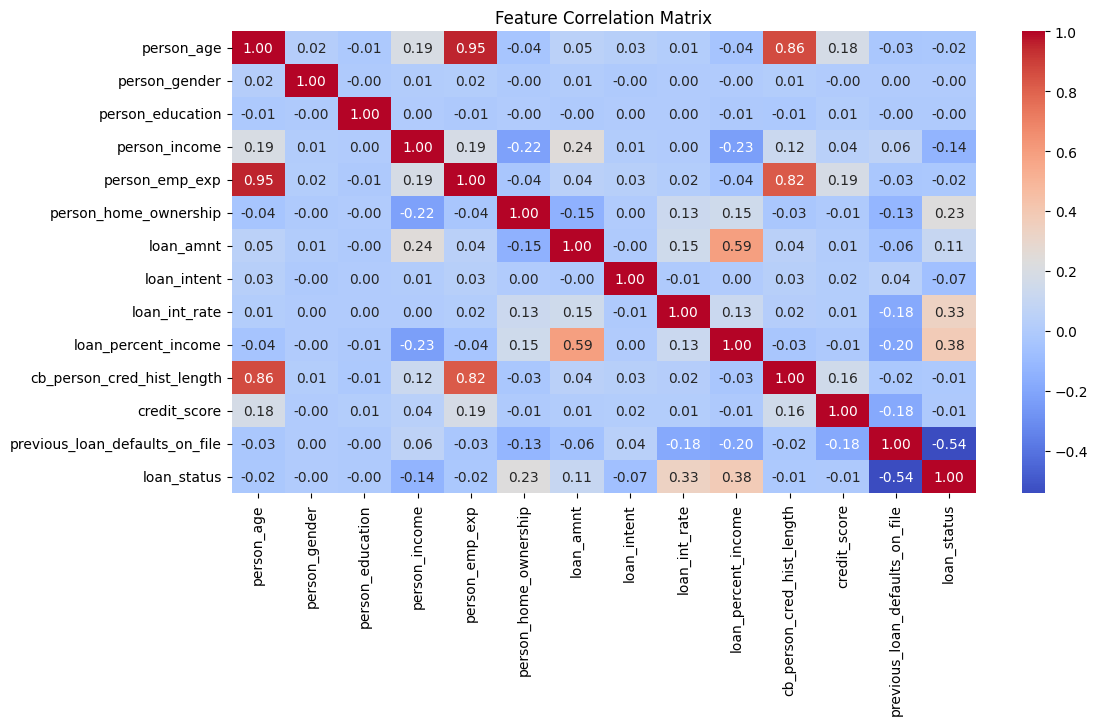


Feature Engineering and EDA completed. Processed data saved.


In [10]:
file_path = "../data/loan_data.csv"  
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Info:")
print(df.info())

# Descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Convert categorical variables
categorical_features = ["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"]
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]

df[numerical_features] = scaler.fit_transform(df[numerical_features])


## Feature Engineering

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd

# Load the data
df = pd.read_csv("../data/loan_data.csv")

# Drop unnecessary columns (but keep loan_status)
drop_columns = [
    "person_age",  # Highly correlated with employment experience
    "person_gender",  # Likely not useful for prediction
    "person_education",  # No strong correlation with loan status
    "person_emp_exp",  # Highly correlated with credit history length
    "cb_person_cred_hist_length"  # Strong correlation with employment experience
]
df = df.drop(columns=drop_columns)

# Ensure previous_loan_defaults_on_file is properly encoded
df["previous_loan_defaults_on_file"] = df["previous_loan_defaults_on_file"].map({"Yes": 1, "No": 0})
df["previous_loan_defaults_on_file"] = df["previous_loan_defaults_on_file"].fillna(0).astype(int)

# Feature Engineering: Create new features
df["income_to_loan_ratio"] = df["person_income"] / df["loan_amnt"]
df["credit_risk_score"] = df["credit_score"] * (1 - df["loan_percent_income"])  # Adjusted credit score
df["high_interest_flag"] = (df["loan_int_rate"] > df["loan_int_rate"].median()).astype(int)  # Flag loans with high interest

# Drop original person_income and loan_amnt after creating income_to_loan_ratio
df = df.drop(columns=["person_income", "loan_amnt"])

# Keep the 'loan_status' column for the final dataset
loan_status = df['loan_status']

# Standardize numerical features
numerical_features = ["loan_percent_income", "loan_int_rate", "credit_score", "income_to_loan_ratio", "credit_risk_score"]

# OneHotEncoder for categorical columns (person_home_ownership and loan_intent)
categorical_features = ["person_home_ownership", "loan_intent"]
categorical_transformer = OneHotEncoder(drop='first', sparse=False)

# Create the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Convert transformed data back to DataFrame for easier inspection
# Get feature names after OneHotEncoding
encoded_columns = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
columns = numerical_features + list(encoded_columns)

# Create a DataFrame with the transformed data
df_transformed = pd.DataFrame(df_transformed, columns=columns)

# Add 'loan_status' column back to the DataFrame
df_transformed['loan_status'] = loan_status

# Save processed data
df_transformed.to_csv("../data/processed_loan_data.csv", index=False)

print("Feature Engineering Complete! Processed data saved to 'data/processed_loan_data.csv'.")


/Users/kingnutmegs/Documents/GitHub/BankLoanDataProject/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Feature Engineering Complete! Processed data saved to 'data/processed_loan_data.csv'.


## Training of Simple MLP

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load processed data
df = pd.read_csv("../data/processed_loan_data.csv")

# Define target and features
X = df.drop(columns=["loan_status"]).values
y = df["loan_status"].values

# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make it 2D
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class LoanNN(nn.Module):
    def __init__(self, input_size):
        super(LoanNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = LoanNN(input_size)

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predicted = (outputs > 0.5).float()
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), "../python/models/loan_fnn_model.pth")
print("Model saved successfully!")


Epoch 10/50, Loss: 0.2866
Epoch 20/50, Loss: 0.4887
Epoch 30/50, Loss: 0.2614
Epoch 40/50, Loss: 0.3063
Epoch 50/50, Loss: 0.2987
Test Accuracy: 0.8794
Model saved successfully!
